## Dependências

In [1]:
!pip install pyspark
# !pip install nltk
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Inicialização

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

# Desconecta o SparkContext, caso esteja conectado
#sc.stop()

# Opção 1
conf = SparkConf().setMaster("local").setAppName("tp3")

# Opção 2 
#conf = SparkConf().setMaster("spark://10.208.205.1:7077").setAppName("UFAM-Lab1")


# Conecta ao Cluster Spark
sc = SparkContext.getOrCreate(conf = conf) 

# Define um "entry point" para toda as operação SPARK SQL
sqlc = SQLContext(sc)

In [3]:
# import pandas as pd
# from pyspark import *
# from pyspark.sql import *

# spark = SparkSession.builder.appName('tweet-SA').getOrCreate()
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', None)

## Leitura dos dados

In [4]:
!wget https://github.com/erlonbie/twitter-sentiment-analysis-kmeans-pyspark/raw/main/train.csv

--2023-02-02 02:51:07--  https://github.com/erlonbie/twitter-sentiment-analysis-kmeans-pyspark/raw/main/train.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/erlonbie/twitter-sentiment-analysis-kmeans-pyspark/main/train.csv [following]
--2023-02-02 02:51:08--  https://raw.githubusercontent.com/erlonbie/twitter-sentiment-analysis-kmeans-pyspark/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/plain]
Saving to: ‘train.csv.2’

train.csv.2         100%[===================>]   2.96M  --.-KB/s    in 0.07s   

2023-02-02 02:51:08 (43.6 MB/s) - ‘train.csv.2’ saved 

In [5]:
cases = sqlc.read.load("train.csv",
                       format="csv", 
                       sep=",", 
                       inferSchema="true", 
                       header="true")
cases.show()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows



## Tratamento dos dados

In [6]:
cases = cases.fillna({'tweet':''})

In [7]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='tweet', outputCol='tokens')
cases = tokenizer.transform(cases)

In [ ]:
cases = cases.toPandas()
cases['tokens'] = cases['tokens'].apply(lambda x: list(filter(lambda y: y != '', x)))
cases = sqlc.createDataFrame(cases)

In [9]:
cases.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|              tokens|
+---+-----+--------------------+--------------------+
|  1|    0| @user when a fat...|[@user, when, a, ...|
|  2|    0|@user @user thank...|[@user, @user, th...|
|  3|    0|  bihday your maj...|[bihday, your, ma...|
|  4|    0|#model   i love u...|[#model, i, love,...|
|  5|    0| factsguide: soci...|[factsguide:, soc...|
|  6|    0|[2/2] huge fan fa...|[[2/2], huge, fan...|
|  7|    0| @user camping to...|[@user, camping, ...|
|  8|    0|the next school y...|[the, next, schoo...|
|  9|    0|we won!!! love th...|[we, won!!!, love...|
| 10|    0| @user @user welc...|[@user, @user, we...|
| 11|    0| â #ireland con...|[â, #ireland, c...|
| 12|    0|we are so selfish...|[we, are, so, sel...|
| 13|    0|i get to see my d...|[i, get, to, see,...|
| 14|    1|@user #cnn calls ...|[@user, #cnn, cal...|
| 15|    1|no comment!  in #...|[no, comment!, in...|
| 16|    0|ouch...junior is 

In [10]:
# rdd = cases.rdd.map(lambda x: (x['id'], x['label'], x['tweet'], list(filter(lambda x: x != '', x['tokens']))))
# cases = rdd.toDF(cases.columns)
# cases.show()

## TF-IDF 

In [11]:
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF

hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

## K-means 

In [12]:
# KMeans Clustering 

from pyspark.ml.clustering import KMeans

numIterations = 200 
numberClusters = 2
kmeans = KMeans().setMaxIter(numIterations).setK(numberClusters).setSeed(1).setDistanceMeasure('cosine') 

## Versão 1

In [13]:
from pyspark.sql.functions import monotonically_increasing_id,filter as filter_spark, size, transform

cases_v1 = cases
cases_v1 = cases_v1.withColumn('tokens', filter_spark('tokens', lambda x: ~x.contains('#')))
cases_v1 = cases_v1.where(size(cases_v1.tokens) != 0)
cases_v1.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|              tokens|
+---+-----+--------------------+--------------------+
|  1|    0| @user when a fat...|[@user, when, a, ...|
|  2|    0|@user @user thank...|[@user, @user, th...|
|  3|    0|  bihday your maj...|[bihday, your, ma...|
|  4|    0|#model   i love u...|[i, love, u, take...|
|  5|    0| factsguide: soci...|[factsguide:, soc...|
|  6|    0|[2/2] huge fan fa...|[[2/2], huge, fan...|
|  7|    0| @user camping to...|[@user, camping, ...|
|  8|    0|the next school y...|[the, next, schoo...|
|  9|    0|we won!!! love th...|[we, won!!!, love...|
| 10|    0| @user @user welc...|[@user, @user, we...|
| 11|    0| â #ireland con...|[â, consumer, p...|
| 12|    0|we are so selfish...|[we, are, so, sel...|
| 13|    0|i get to see my d...|[i, get, to, see,...|
| 14|    1|@user #cnn calls ...|[@user, calls, mi...|
| 15|    1|no comment!  in #...|  [no, comment!, in]|
| 16|    0|ouch...junior is 

In [14]:
# rdd = cases.rdd.map(lambda x:(x['id'], x['label'], x['tweet'], list(filter(lambda x: '#' not in x, x['tokens']))))
# cases_v1 = rdd.toDF(cases.columns)
# cases_v1.show()

In [15]:
cases_v1_model = hashingTF.transform(cases_v1)
idfModel = idf.fit(cases_v1_model)
cases_v1_model = idfModel.transform(cases_v1_model)
cases_v1_model.limit(5).toPandas()

,id,label,tweet,tokens,rawFeatures,features
0,1,0,@user when a father is dysfunctional and is s...,"[@user, when, a, father, is, dysfunctional, an...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 5.2285409801733955, 0.0, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[@user, @user, thanks, for, credit, i, can't, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,0,bihday your majesty,"[bihday, your, majesty]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,0,#model i love u take with u all the time in ...,"[i, love, u, take, with, u, all, the, time, in...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,0,factsguide: society now #motivation,"[factsguide:, society, now]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
kmeans_model = kmeans.fit(cases_v1_model)
predictions_v1 = kmeans_model.transform(cases_v1_model)
predictions_v1.select('id','tweet','label','prediction').limit(5).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,3,bihday your majesty,0,1
3,4,#model i love u take with u all the time in ...,0,0
4,5,factsguide: society now #motivation,0,0


In [17]:
predictions_v1.select('id','tweet','label','prediction').limit(100).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,3,bihday your majesty,0,1
3,4,#model i love u take with u all the time in ...,0,0
4,5,factsguide: society now #motivation,0,0
...,...,...,...,...
95,96,@user i'll always hope that one day i'll get t...,0,0
96,97,#model i love u take with u all the time in ...,0,0
97,98,couple having sex fat naked japanese girls,0,1
98,99,#hump on that #hump day #humpersð© @ edwa...,0,1


### Avaliação V1

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, cast


p_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
predictions_v1_temp = predictions_v1.withColumn("prediction", predictions_v1.prediction.cast("double"))
prec1 = p_evaluator.evaluate(predictions_v1_temp)
prec1


0.8552464206051131

In [19]:
r_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedRecall")
rec1 = r_evaluator.evaluate(predictions_v1_temp)
rec1


0.7121715683200601

## Versão 2

In [20]:
cases_v2 = cases
cases_v2 = cases_v2.withColumn('tokens', filter_spark('tokens', lambda x: x.contains('#')))
cases_v2 = cases_v2.where(size(cases_v2.tokens) != 0)
cases_v2.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|              tokens|
+---+-----+--------------------+--------------------+
|  1|    0| @user when a fat...|              [#run]|
|  2|    0|@user @user thank...|[#lyft, #disapoin...|
|  4|    0|#model   i love u...|            [#model]|
|  5|    0| factsguide: soci...|       [#motivation]|
|  6|    0|[2/2] huge fan fa...|   [#allshowandnogo]|
|  8|    0|the next school y...|[#school, #exams,...|
|  9|    0|we won!!! love th...|[#allin, #cavs, #...|
| 10|    0| @user @user welc...|              [#gr8]|
| 11|    0| â #ireland con...|[#ireland, #blog,...|
| 12|    0|we are so selfish...|[#orlando, #stand...|
| 13|    0|i get to see my d...|[#80days, #gettin...|
| 14|    1|@user #cnn calls ...|[#cnn, #michigan,...|
| 15|    1|no comment!  in #...|[#australia, #opk...|
| 16|    0|ouch...junior is ...|[angryð#got7, ...|
| 17|    0|i am thankful for...|[#thankful, #posi...|
| 19|    0|its #friday! ð

In [21]:
cases_v2_model = hashingTF.transform(cases_v2)
idfModel = idf.fit(cases_v2_model)
cases_v2_model = idfModel.transform(cases_v2_model)
cases_v2_model.limit(5).toPandas()

,id,label,tweet,tokens,rawFeatures,features
0,1,0,@user when a father is dysfunctional and is s...,[#run],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[#lyft, #disapointed, #getthanked]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,4,0,#model i love u take with u all the time in ...,[#model],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5,0,factsguide: society now #motivation,[#motivation],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6,0,[2/2] huge fan fare and big talking before the...,[#allshowandnogo],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
kmeans_model_v2 = kmeans.fit(cases_v2_model)
predictions_v2 = kmeans_model_v2.transform(cases_v2_model)
predictions_v2.select('id','tweet','label','prediction').limit(5).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,4,#model i love u take with u all the time in ...,0,0
3,5,factsguide: society now #motivation,0,0
4,6,[2/2] huge fan fare and big talking before the...,0,0


In [23]:
predictions_v2.select('id','tweet','label','prediction').limit(100).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,4,#model i love u take with u all the time in ...,0,0
3,5,factsguide: society now #motivation,0,0
4,6,[2/2] huge fan fare and big talking before the...,0,0
...,...,...,...,...
95,128,sad in the branches itâs just rainy day writ...,0,0
96,129,yeah! new buttons in the mail for me ð the...,0,0
97,130,@user driver hit female moose on river rd #we...,0,0
98,131,afterpas. made in japan. ï¼madeinjapan #eo...,0,0


### Avaliação V2

In [24]:
p_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
predictions_v2_temp = predictions_v2.withColumn("prediction", predictions_v2.prediction.cast("double"))
prec2 = p_evaluator.evaluate(predictions_v2_temp)
prec2


0.8655973423861877

In [25]:
r_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedRecall")
rec2 = r_evaluator.evaluate(predictions_v2_temp)
rec2


0.8733114586440534

## Versão 3

In [26]:
cases_v3 = cases
cases_v3.show()

+---+-----+--------------------+--------------------+
| id|label|               tweet|              tokens|
+---+-----+--------------------+--------------------+
|  1|    0| @user when a fat...|[@user, when, a, ...|
|  2|    0|@user @user thank...|[@user, @user, th...|
|  3|    0|  bihday your maj...|[bihday, your, ma...|
|  4|    0|#model   i love u...|[#model, i, love,...|
|  5|    0| factsguide: soci...|[factsguide:, soc...|
|  6|    0|[2/2] huge fan fa...|[[2/2], huge, fan...|
|  7|    0| @user camping to...|[@user, camping, ...|
|  8|    0|the next school y...|[the, next, schoo...|
|  9|    0|we won!!! love th...|[we, won!!!, love...|
| 10|    0| @user @user welc...|[@user, @user, we...|
| 11|    0| â #ireland con...|[â, #ireland, c...|
| 12|    0|we are so selfish...|[we, are, so, sel...|
| 13|    0|i get to see my d...|[i, get, to, see,...|
| 14|    1|@user #cnn calls ...|[@user, #cnn, cal...|
| 15|    1|no comment!  in #...|[no, comment!, in...|
| 16|    0|ouch...junior is 

In [27]:
cases_v3_model = hashingTF.transform(cases_v3)
idfModel = idf.fit(cases_v3_model)
cases_v3_model = idfModel.transform(cases_v3_model)
cases_v3_model.limit(5).toPandas()

,id,label,tweet,tokens,rawFeatures,features
0,1,0,@user when a father is dysfunctional and is s...,"[@user, when, a, father, is, dysfunctional, an...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 5.044458094019535, 0.0, 0..."
1,2,0,@user @user thanks for #lyft credit i can't us...,"[@user, @user, thanks, for, #lyft, credit, i, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,0,bihday your majesty,"[bihday, your, majesty]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,0,#model i love u take with u all the time in ...,"[#model, i, love, u, take, with, u, all, the, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,0,factsguide: society now #motivation,"[factsguide:, society, now, #motivation]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
kmeans_model = kmeans.fit(cases_v3_model)
predictions_v3 = kmeans_model.transform(cases_v3_model)
predictions_v3.select('id','tweet','label','prediction').limit(5).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,3,bihday your majesty,0,1
3,4,#model i love u take with u all the time in ...,0,0
4,5,factsguide: society now #motivation,0,0


In [29]:
predictions_v1.select('id','tweet','label','prediction').limit(100).toPandas()

,id,tweet,label,prediction
0,1,@user when a father is dysfunctional and is s...,0,0
1,2,@user @user thanks for #lyft credit i can't us...,0,0
2,3,bihday your majesty,0,1
3,4,#model i love u take with u all the time in ...,0,0
4,5,factsguide: society now #motivation,0,0
...,...,...,...,...
95,96,@user i'll always hope that one day i'll get t...,0,0
96,97,#model i love u take with u all the time in ...,0,0
97,98,couple having sex fat naked japanese girls,0,1
98,99,#hump on that #hump day #humpersð© @ edwa...,0,1


### Avaliação V3

In [30]:
p_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedPrecision")
predictions_v3_temp = predictions_v3.withColumn("prediction", predictions_v3.prediction.cast("double"))
prec3 = p_evaluator.evaluate(predictions_v3_temp)
prec3


0.8745809168305054

In [31]:
r_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="weightedRecall")
rec3 = r_evaluator.evaluate(predictions_v3_temp)
rec3


0.7372191977973844

### Gráficos

## Gráfico comparativo

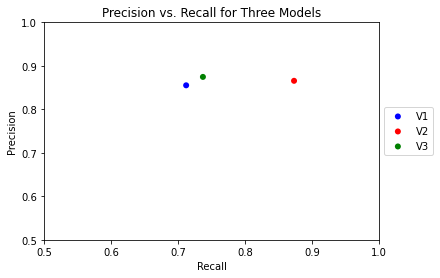

In [33]:
import matplotlib.pyplot as plt

precision = [prec1 , prec2, prec3]
recall = [rec1, rec2, rec3]
labels = ['V1', 'V2', 'V3']

colors = ['blue', 'red', 'green']

fig, ax = plt.subplots()
plt.margins(0.2)

for i, color in enumerate(colors):
    ax.scatter(c=color, x=recall[i], y=precision[i], label=labels[i], edgecolors='none')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall for Three Models')
plt.axis([0.5, 1.0, 0.5, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


plt.show()
